<h1>Medición de la carga cognitiva de ciertas tareas mediante métodos alternativos e indirectos.</h1>


<h1 style="font-size:15px;">Histograma de duraciones de series originales</h1>

Duración de la serie más larga 120.0
Duración de la serie más pequeña 118.559
48


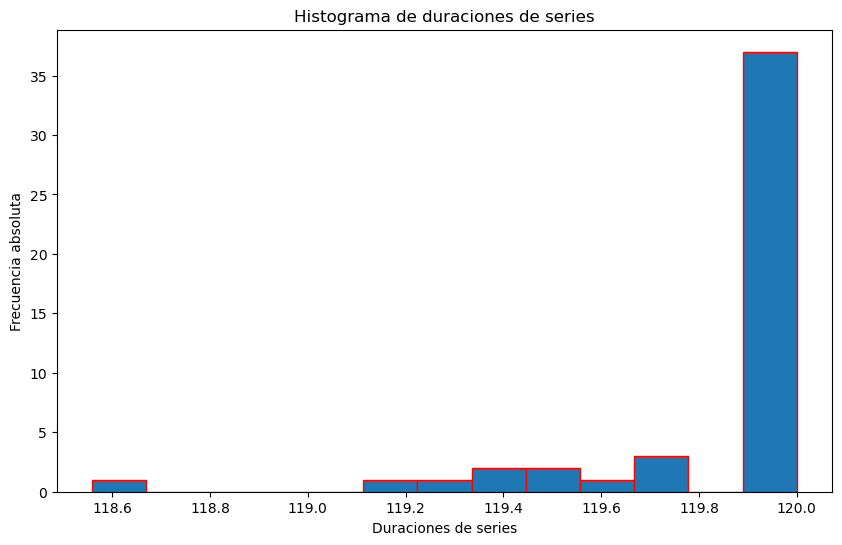

In [60]:
for archivo in archivos:
    if archivo.endswith('.txt'):
        ruta_completa = folder_directory + archivo
        df_tmp = pd.read_csv(ruta_completa, header=None, names=['x', 'y', 'timestamp'])
        series[archivo] = df_tmp
        if df_tmp.shape[0] > 0 and df_tmp.shape[1] == 3:
            instante_inicial = df_tmp.iloc[0, 2]
            instante_final = df_tmp.iloc[-1, 2]
            diferencia_seg = (instante_final - instante_inicial) / 1000.0  # Conversión a segundos
            tiempos.append(diferencia_seg)
        

print("Duración de la serie más larga " + str(max(tiempos)))
print("Duración de la serie más pequeña " + str(min(tiempos)))
print(len(archivos))
plt.figure(figsize=(10, 6))
plt.hist(tiempos, bins=len(set(tiempos)), edgecolor='red')
# Personalizacion del histograma
plt.xlabel('Duraciones de series')
plt.ylabel('Frecuencia absoluta')
plt.title('Histograma de duraciones de series')

# Mostrar el histograma
plt.show()


<h1 style="font-size:15px;">Eliminacion de outsiders en porcentaje tanto al inicio como al final</h1>

Archivos eliminados después de aplicar percentiles:


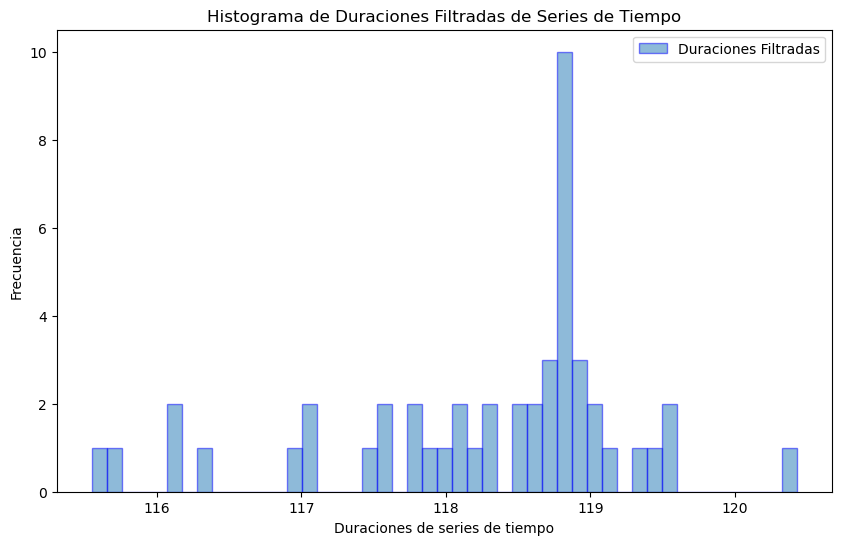

0
Cantidad de series de tiempo luego del tratamiento de datos: 48


In [61]:
porcentaje_eliminacion = 0.5  # Puedes cambiar este valor a 0 para no eliminar ningún dato
archivos = [f for f in os.listdir(folder_directory) if f.endswith('.txt')]

# Estructura para almacenar las duraciones de las series filtradas y los nombres de archivos correspondientes
duraciones_y_archivos = []

for archivo in archivos:
    ruta_completa = os.path.join(folder_directory, archivo)
    df = pd.read_csv(ruta_completa, header=None, names=['x', 'y', 'timestamp'])

    # Eliminar porcentajes de datos del inicio y final solo si el porcentaje no es 0
    num_datos = len(df)
    if porcentaje_eliminacion > 0:
        datos_a_eliminar = int(np.floor(porcentaje_eliminacion / 100 * num_datos))
        df_filtrada = df[datos_a_eliminar:-datos_a_eliminar]
    else:
        df_filtrada = df.copy()

    # Calcular la duración de la serie filtrada
    if not df_filtrada.empty:
        duracion = (df_filtrada['timestamp'].iloc[-1] - df_filtrada['timestamp'].iloc[0]) / 1000.0
        duraciones_y_archivos.append((duracion, archivo))

# Aplicar el filtro de percentiles
duraciones = [d[0] for d in duraciones_y_archivos]
percentil_inicio = np.percentile(duraciones, 0)
percentil_fin = np.percentile(duraciones, 100)

# Identificar los archivos que cumplen con el filtro de percentiles
archivos_filtrados = [archivo for duracion, archivo in duraciones_y_archivos if percentil_inicio <= duracion <= percentil_fin]

# Conjuntos para identificar los archivos eliminados
archivos_antes = set(archivos)
archivos_despues = set(archivos_filtrados)
archivos_eliminados = archivos_antes - archivos_despues

# Imprimir los archivos eliminados
print("Archivos eliminados después de aplicar percentiles:")
for archivo in archivos_eliminados:
    print(archivo)

# Visualización de histograma de duraciones filtradas
tiempos_filtrados = [duracion for duracion, _ in duraciones_y_archivos if percentil_inicio <= duracion <= percentil_fin]
plt.figure(figsize=(10, 6))
plt.hist(tiempos_filtrados, bins=len(set(tiempos_filtrados)), edgecolor='blue', alpha=0.5, label='Duraciones Filtradas')
plt.xlabel('Duraciones de series de tiempo')
plt.ylabel('Frecuencia')
plt.title('Histograma de Duraciones Filtradas de Series de Tiempo')
plt.legend()
plt.show()
print(len(archivos_eliminados))
print(f'Cantidad de series de tiempo luego del tratamiento de datos: {len(archivos_filtrados)}')

<h1 style="font-size:20px;">RESAMPLING</h1>

<h1 style="font-size:15px;">Proceso de resampling</h1>


In [62]:
series_resampled = dict()

# Considerar solo los archivos que no fueron eliminados
archivos_no_eliminados = set(archivos) - archivos_eliminados

for archivo in archivos_no_eliminados:
    ruta_completa = os.path.join(folder_directory, archivo)
    df = pd.read_csv(ruta_completa, header=None, names=['x', 'y', 'timestamp'])

    # Eliminación de porcentajes de datos
    num_datos = len(df)
    datos_a_eliminar = int(np.floor(porcentaje_eliminacion / 100 * num_datos))
    # Asegurarse de trabajar con una copia para evitar SettingWithCopyWarning
    df_filtrada = df[datos_a_eliminar:-datos_a_eliminar].copy()

    # Convertir timestamp a datetime y alinear serie
    df_filtrada["timestamp"] = pd.to_datetime(df_filtrada["timestamp"], unit="ms")
    instante_inicial = df_filtrada.iloc[0]["timestamp"]
    df_filtrada["timestamp"] = df_filtrada["timestamp"] - instante_inicial

    # Resampling e Interpolación
    df_filtrada.set_index('timestamp', inplace=True)
    df_resampled = df_filtrada.resample(freq).mean()
    df_resampled['x'] = df_resampled['x'].interpolate()
    df_resampled['y'] = df_resampled['y'].interpolate()
    df_resampled.reset_index(inplace=True)

    # Almacenar en el nuevo diccionario
    series_resampled[archivo] = df_resampled


In [63]:
print(series_resampled)

{'Modified_P43-SecuencialDificil.txt':                   timestamp      x      y
0           0 days 00:00:00  646.0  269.0
1    0 days 00:00:00.015000  644.0  265.0
2    0 days 00:00:00.030000  643.0  260.0
3    0 days 00:00:00.045000  641.0  255.0
4    0 days 00:00:00.060000  639.0  249.0
...                     ...    ...    ...
7919 0 days 00:01:58.785000  372.0  359.0
7920 0 days 00:01:58.800000  374.0  365.0
7921 0 days 00:01:58.815000  376.0  370.0
7922 0 days 00:01:58.830000  377.0  372.5
7923 0 days 00:01:58.845000  378.0  375.0

[7924 rows x 3 columns], 'Modified_P41-NumericoFacil.txt':                   timestamp           x           y
0           0 days 00:00:00  492.000000  137.000000
1    0 days 00:00:00.015000  479.000000  136.000000
2    0 days 00:00:00.030000  465.000000  136.000000
3    0 days 00:00:00.045000  450.000000  136.000000
4    0 days 00:00:00.060000  436.000000  137.000000
...                     ...         ...         ...
7858 0 days 00:01:57.870000  518.

<h1 style="font-size:20px;">INTERPOLACION Y STRETCHING</h1> 

In [64]:
# Encuentra la longitud máxima entre todas las series
min_interpolacion= 0
max_interpolacion=1

max_valor = max([df.shape[0] for df in series_resampled.values()])
min_valor = min([df.shape[0] for df in series_resampled.values()])
max_valor = 8021
print('Maximo valor de serie: '+str(max_valor))
print('Minimo valor de serie: '+str(min_valor))

# Diccionario para almacenar las series estiradas
series_estiradas = {}

# Estirar cada serie para que coincida con la longitud máxima
for key, df_tmp in series_resampled.items():
    tamano_serie_tmp = df_tmp.shape[0]
   
    
    # Crear ejes de interpolación
    x_shorter = np.linspace(0, 1, tamano_serie_tmp)
    x_longer = np.linspace(0, 1, max_valor)
    # Funciones de interpolación
    interpolatorx = interp1d(x_shorter, df_tmp['x'])
    interpolatory = interp1d(x_shorter, df_tmp['y'])

    # Interpolar para estirar la serie
    stretched_seriesx = interpolatorx(x_longer)
    stretched_seriesy = interpolatory(x_longer)

    # Crear un nuevo DataFrame
    df_nuevo = pd.DataFrame({'Eje uniforme': x_longer, 'x': stretched_seriesx, 'y': stretched_seriesy})
    series_estiradas[key] = df_nuevo
    




Maximo valor de serie: 8021
Minimo valor de serie: 7704


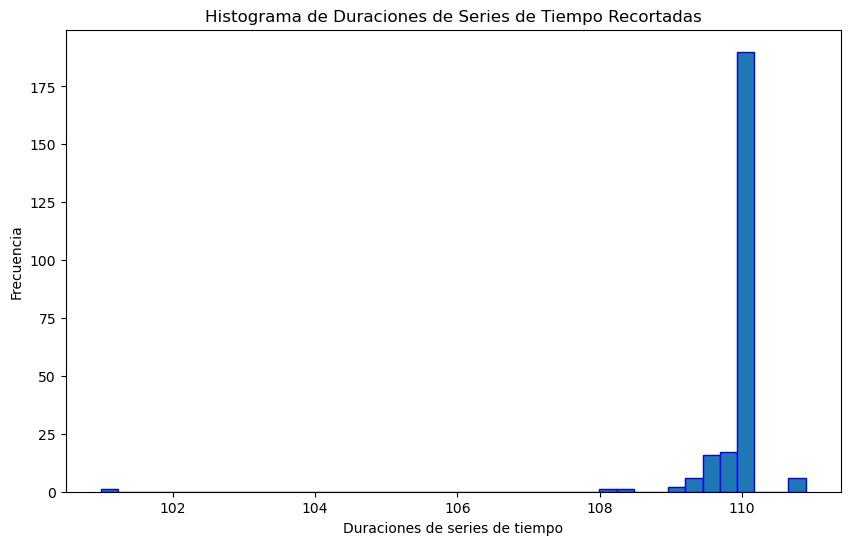

Proceso de preprocesamiento finalizado. Todas las series ahora tienen la misma duración.


In [2]:
from scipy.interpolate import interp1d
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt

# Directorio de las series temporales
folder_directory = 'C:\\Users\\Rodne\\Desktop\\drawingsFiltered\\'

# Frecuencia de resampling
freq = '0.0150S'

# Función para extraer la clave de ordenación basada en el nombre del archivo
def obtener_clave(archivo):
    patron = r"P(\d+)-(\w+)-(\w+)-"
    coincidencia = re.match(patron, archivo)
    if coincidencia:
        numero_participante = int(coincidencia.group(1))
        tarea = coincidencia.group(2)
        dificultad = coincidencia.group(3)
        return (numero_participante, tarea, dificultad)
    return archivo

# Obtener y ordenar archivos de series temporales
archivos = sorted([f for f in os.listdir(folder_directory) if f.endswith('.txt')], key=obtener_clave)

# Almacenar series resampleadas y sus duraciones
series_resampled = dict()
duraciones = dict()

for archivo in archivos:
    ruta_completa = os.path.join(folder_directory, archivo)
    df = pd.read_csv(ruta_completa, header=None, names=['x', 'y', 'timestamp'])
    
    # Convertir timestamp a datetime y alinear la serie
    df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
    instante_inicial = df.iloc[0]["timestamp"]
    df["timestamp"] = df["timestamp"] - instante_inicial
    
    # Resampling e Interpolación
    df.set_index('timestamp', inplace=True)
    df_resampled = df.resample(freq).mean()
    df_resampled['x'] = df_resampled['x'].interpolate()
    df_resampled['y'] = df_resampled['y'].interpolate()
    df_resampled.reset_index(inplace=True)
    
    # Guardar la serie resampleada y su duración
    series_resampled[archivo] = df_resampled
    duraciones[archivo] = df_resampled['timestamp'].iloc[-1]

# Encontrar la duración mínima entre todas las series
min_duracion = min(duraciones.values())

# Recortar todas las series a la duración mínima
series_recortadas = dict()
for archivo, df in series_resampled.items():
    duracion_actual = duraciones[archivo]
    
    if duracion_actual > min_duracion:
        exceso_tiempo = (duracion_actual - min_duracion).total_seconds()
        eliminar_inicio = int(np.floor(exceso_tiempo / 2))
        eliminar_fin = int(np.ceil(exceso_tiempo / 2))
        
        df = df[(df['timestamp'] >= pd.Timedelta(seconds=eliminar_inicio)) &
                (df['timestamp'] <= pd.Timedelta(seconds=(duracion_actual.total_seconds() - eliminar_fin)))]
        
    series_recortadas[archivo] = df

# Visualización del histograma de duraciones después del recorte
duraciones_finales = [df['timestamp'].iloc[-1].total_seconds() for df in series_recortadas.values()]
plt.figure(figsize=(10, 6))
plt.hist(duraciones_finales, bins=len(set(duraciones_finales)), edgecolor='blue')
plt.xlabel('Duraciones de series de tiempo')
plt.ylabel('Frecuencia')
plt.title('Histograma de Duraciones de Series de Tiempo Recortadas')
plt.show()

print("Proceso de preprocesamiento finalizado. Todas las series ahora tienen la misma duración.")


In [3]:
for archivo, df in series_recortadas.items():
    nan_count = df.isna().sum().sum()  # Suma todos los NaN en el DataFrame
    print(f"Archivo: {archivo} - Total NaNs: {nan_count}")


Archivo: P1-NumericoDificil-02-08-2024-T11-47-20.498.txt - Total NaNs: 0
Archivo: P1-NumericoFacil-02-08-2024-T11-49-55.568.txt - Total NaNs: 0
Archivo: P1-SecuencialDificil-02-08-2024-T11-39-29.285.txt - Total NaNs: 0
Archivo: P1-SecuencialFacil-02-08-2024-T11-34-56.743.txt - Total NaNs: 0
Archivo: P1-VerbalDificil-02-08-2024-T11-41-49.49.txt - Total NaNs: 0
Archivo: P1-VerbalFacil-02-08-2024-T11-44-58.825.txt - Total NaNs: 0
Archivo: P2-NumericoDificil-02-19-2024-T14-42-26.629.txt - Total NaNs: 0
Archivo: P2-NumericoFacil-02-19-2024-T14-45-15.354.txt - Total NaNs: 0
Archivo: P2-SecuencialDificil-02-19-2024-T14-36-08.318.txt - Total NaNs: 0
Archivo: P2-SecuencialFacil-02-19-2024-T14-38-35.528.txt - Total NaNs: 0
Archivo: P2-VerbalDificil-02-19-2024-T14-33-40.541.txt - Total NaNs: 0
Archivo: P2-VerbalFacil-02-19-2024-T14-31-00.337.txt - Total NaNs: 0
Archivo: P3-NumericoDificil-12-08-2023-T09-27-39.330.txt - Total NaNs: 0
Archivo: P3-NumericoFacil-12-08-2023-T09-30-10.548.txt - Total N

<h1 style="font-size:20px;">PROCESO DE ETIQUETADO</h1>

<h1 style="font-size:16px;">ETIQUETAS POR DIFICULTAD DE LAS TAREAS: "FACIL" y "DIFICIL"</h1>

In [7]:
# Ordenar las series recortadas en el mismo orden que los archivos
series_recortadas_ordenadas = {archivo: series_recortadas[archivo] for archivo in archivos}

# Ahora realiza el etiquetado asegurando que sigue el orden correcto
datos_transformados = []
etiquetas = []

def obtener_etiqueta(nombre_archivo):
    if 'Facil' in nombre_archivo:
        return 'facil'
    elif 'Dificil' in nombre_archivo:
        return 'dificil'
    else:
        return 'desconocido'

# 🔥 Determinar la cantidad mínima de puntos después del recorte
min_len_x = min([df.shape[0] for df in series_recortadas_ordenadas.values()])
print(f"La cantidad mínima de puntos en las series después del recorte es: {min_len_x}")

# Crear nombres de columnas
nombres_columnas = ['X{}'.format(i+1) for i in range(min_len_x)] + ['Y{}'.format(i+1) for i in range(min_len_x)]

# Transformar cada serie y almacenar los datos transformados y las etiquetas
for archivo, df in series_recortadas_ordenadas.items():
    # Obtener la etiqueta de la serie
    etiqueta = obtener_etiqueta(archivo)
    
    # 📌 Asegurar que todas las series tienen exactamente `min_len_x` filas
    if df.shape[0] > min_len_x:
        df = df.iloc[:min_len_x]  # Cortar el exceso de puntos
    elif df.shape[0] < min_len_x:
        df = df.reindex(range(min_len_x), method='nearest')  # Interpolar si es menor

    # Aplanar las series X e Y en un solo arreglo
    datos_serie = df['x'].tolist() + df['y'].tolist()

    # 🔥 Verificar que la cantidad de puntos sea correcta
    if len(datos_serie) != 2 * min_len_x:
        print(f"Error en {archivo}: longitud esperada {2 * min_len_x}, obtenida {len(datos_serie)}")

    # Agregar los datos transformados y la etiqueta a las listas
    datos_transformados.append(datos_serie)
    etiquetas.append(etiqueta)

# 🚀 Verificar la cantidad exacta de columnas antes de crear el DataFrame
print(f"Número esperado de columnas: {len(nombres_columnas)}")
print(f"Número real de elementos en una fila: {len(datos_transformados[0])}")

# Crear el DataFrame final
df_final = pd.DataFrame(datos_transformados, columns=nombres_columnas)
df_final['etiqueta'] = etiquetas

# Mostrar una parte del DataFrame para verificar
print(df_final.head())


La cantidad mínima de puntos en las series después del recorte es: 6673
Número esperado de columnas: 13346
Número real de elementos en una fila: 13346
           X1          X2          X3          X4          X5          X6  \
0  617.000000  613.000000  609.000000  605.000000  596.600000  588.200000   
1  521.000000  514.000000  508.000000  499.000000  490.000000  481.000000   
2  470.333333  462.000000  452.166667  442.333333  432.500000  422.666667   
3  389.333333  379.666667  370.000000  366.333333  362.666667  359.000000   
4  347.666667  348.333333  349.000000  349.666667  350.333333  351.000000   

           X7          X8     X9    X10  ...       Y6665       Y6666  \
0  579.800000  571.400000  563.0  554.0  ...  438.000000  440.000000   
1  470.000000  462.500000  455.0  447.0  ...  154.000000  154.000000   
2  412.833333  403.000000  395.8  388.6  ...  472.434783  473.217391   
3  355.333333  351.666667  348.0  356.5  ...  248.717391  245.565217   
4  354.800000  358.600000 

<h1 style="font-size:20px;">Analisis de mini-rocket de sólo coordenadas </h1>

In [10]:
import numpy as np
import pandas as pd


X = df_final.drop(columns=['etiqueta']).values
y = df_final['etiqueta'].values
X_reshaped = X.reshape(-1, 2, min_len_x)
X_reshaped = X_reshaped.astype(np.float32)

In [11]:
print(X_reshaped.shape)

(240, 2, 6673)


In [12]:
from rocket_functions import generate_kernels, apply_kernels
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from minirocket_multivariate import fit, transform

params = fit(X_reshaped, num_features=100, max_dilations_per_kernel=2)
X_transformed = transform(X_reshaped, params)
X_train_transformed, X_test_transformed, y_train, y_test = train_test_split(X_transformed, y, test_size=0.3, random_state=42)


classifier = RandomForestClassifier() 
classifier.fit(X_train_transformed, y_train)

y_pred = classifier.predict(X_test_transformed)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')


Accuracy: 0.7222222222222222


In [13]:
scores = cross_val_score(classifier, X_transformed, y, cv=10)
print(scores)
accuracy_average = np.mean(scores)
print(f'Accuracy promedio con validación cruzada: {accuracy_average}')

[0.79166667 0.54166667 0.54166667 0.625      0.625      0.54166667
 0.83333333 0.91666667 0.875      0.95833333]
Accuracy promedio con validación cruzada: 0.7249999999999999


In [70]:
import os
import re

folder_directory = 'C:\\Users\\Rodne\\Desktop\\drawingsFiltered8\\'

# Función para extraer la clave de ordenación basada en el nombre del archivo
def obtener_clave(archivo):
    # Extraer el número de participante y luego el resto de los componentes del nombre
    patron = r"P(\d+)-(\w+)-(\w+)-"
    coincidencia = re.match(patron, archivo)
    if coincidencia:
        numero_participante = int(coincidencia.group(1))
        tarea = coincidencia.group(2)
        dificultad = coincidencia.group(3)
        return (numero_participante, tarea, dificultad)
    return archivo

# Obtener la lista de archivos y ordenarlos según el patrón personalizado
archivos = sorted([f for f in os.listdir(folder_directory) if f.endswith('.txt')],
                  key=obtener_clave)


<h1 style="font-size:16px;">ANÁLISIS DE VELOCIDAD PARA AGREGAR NUEVO FEATURE"</h1>

In [14]:
import os
import pandas as pd
import numpy as np


porcentaje_eliminar = 1  # Definir el porcentaje de eliminación para el inicio y el final

# Función para calcular las velocidades instantáneas
def calcular_velocidades(df):
    velocidades = []
    for i in range(1, len(df)):
        x1, y1, t1 = df.iloc[i - 1][['x', 'y', 'timestamp']]
        x2, y2, t2 = df.iloc[i][['x', 'y', 'timestamp']]
        distancia = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
        tiempo = (t2 - t1) / 1000.0  # Asumiendo que timestamp está en milisegundos
        if tiempo > 0:
            velocidad = distancia / tiempo
            velocidades.append(velocidad)
        else:
            velocidades.append(0)
    return velocidades

# Diccionario para almacenar las velocidades calculadas de cada archivo
velocidades_por_archivo = {}

# Calcular las velocidades para cada archivo, eliminando el porcentaje indicado al inicio y al final
for archivo in archivos:
    if archivo.endswith('.txt'):
        ruta_completa = os.path.join(folder_directory, archivo)
        df = pd.read_csv(ruta_completa, header=None, names=['x', 'y', 'timestamp'])
        
        # Calcular el número de filas a eliminar al inicio y al final
        filas_a_eliminar = int(len(df) * porcentaje_eliminar / 100)
        df = df.iloc[filas_a_eliminar:-filas_a_eliminar] if filas_a_eliminar > 0 else df
        
        velocidades = calcular_velocidades(df)
        velocidades_por_archivo[archivo] = velocidades


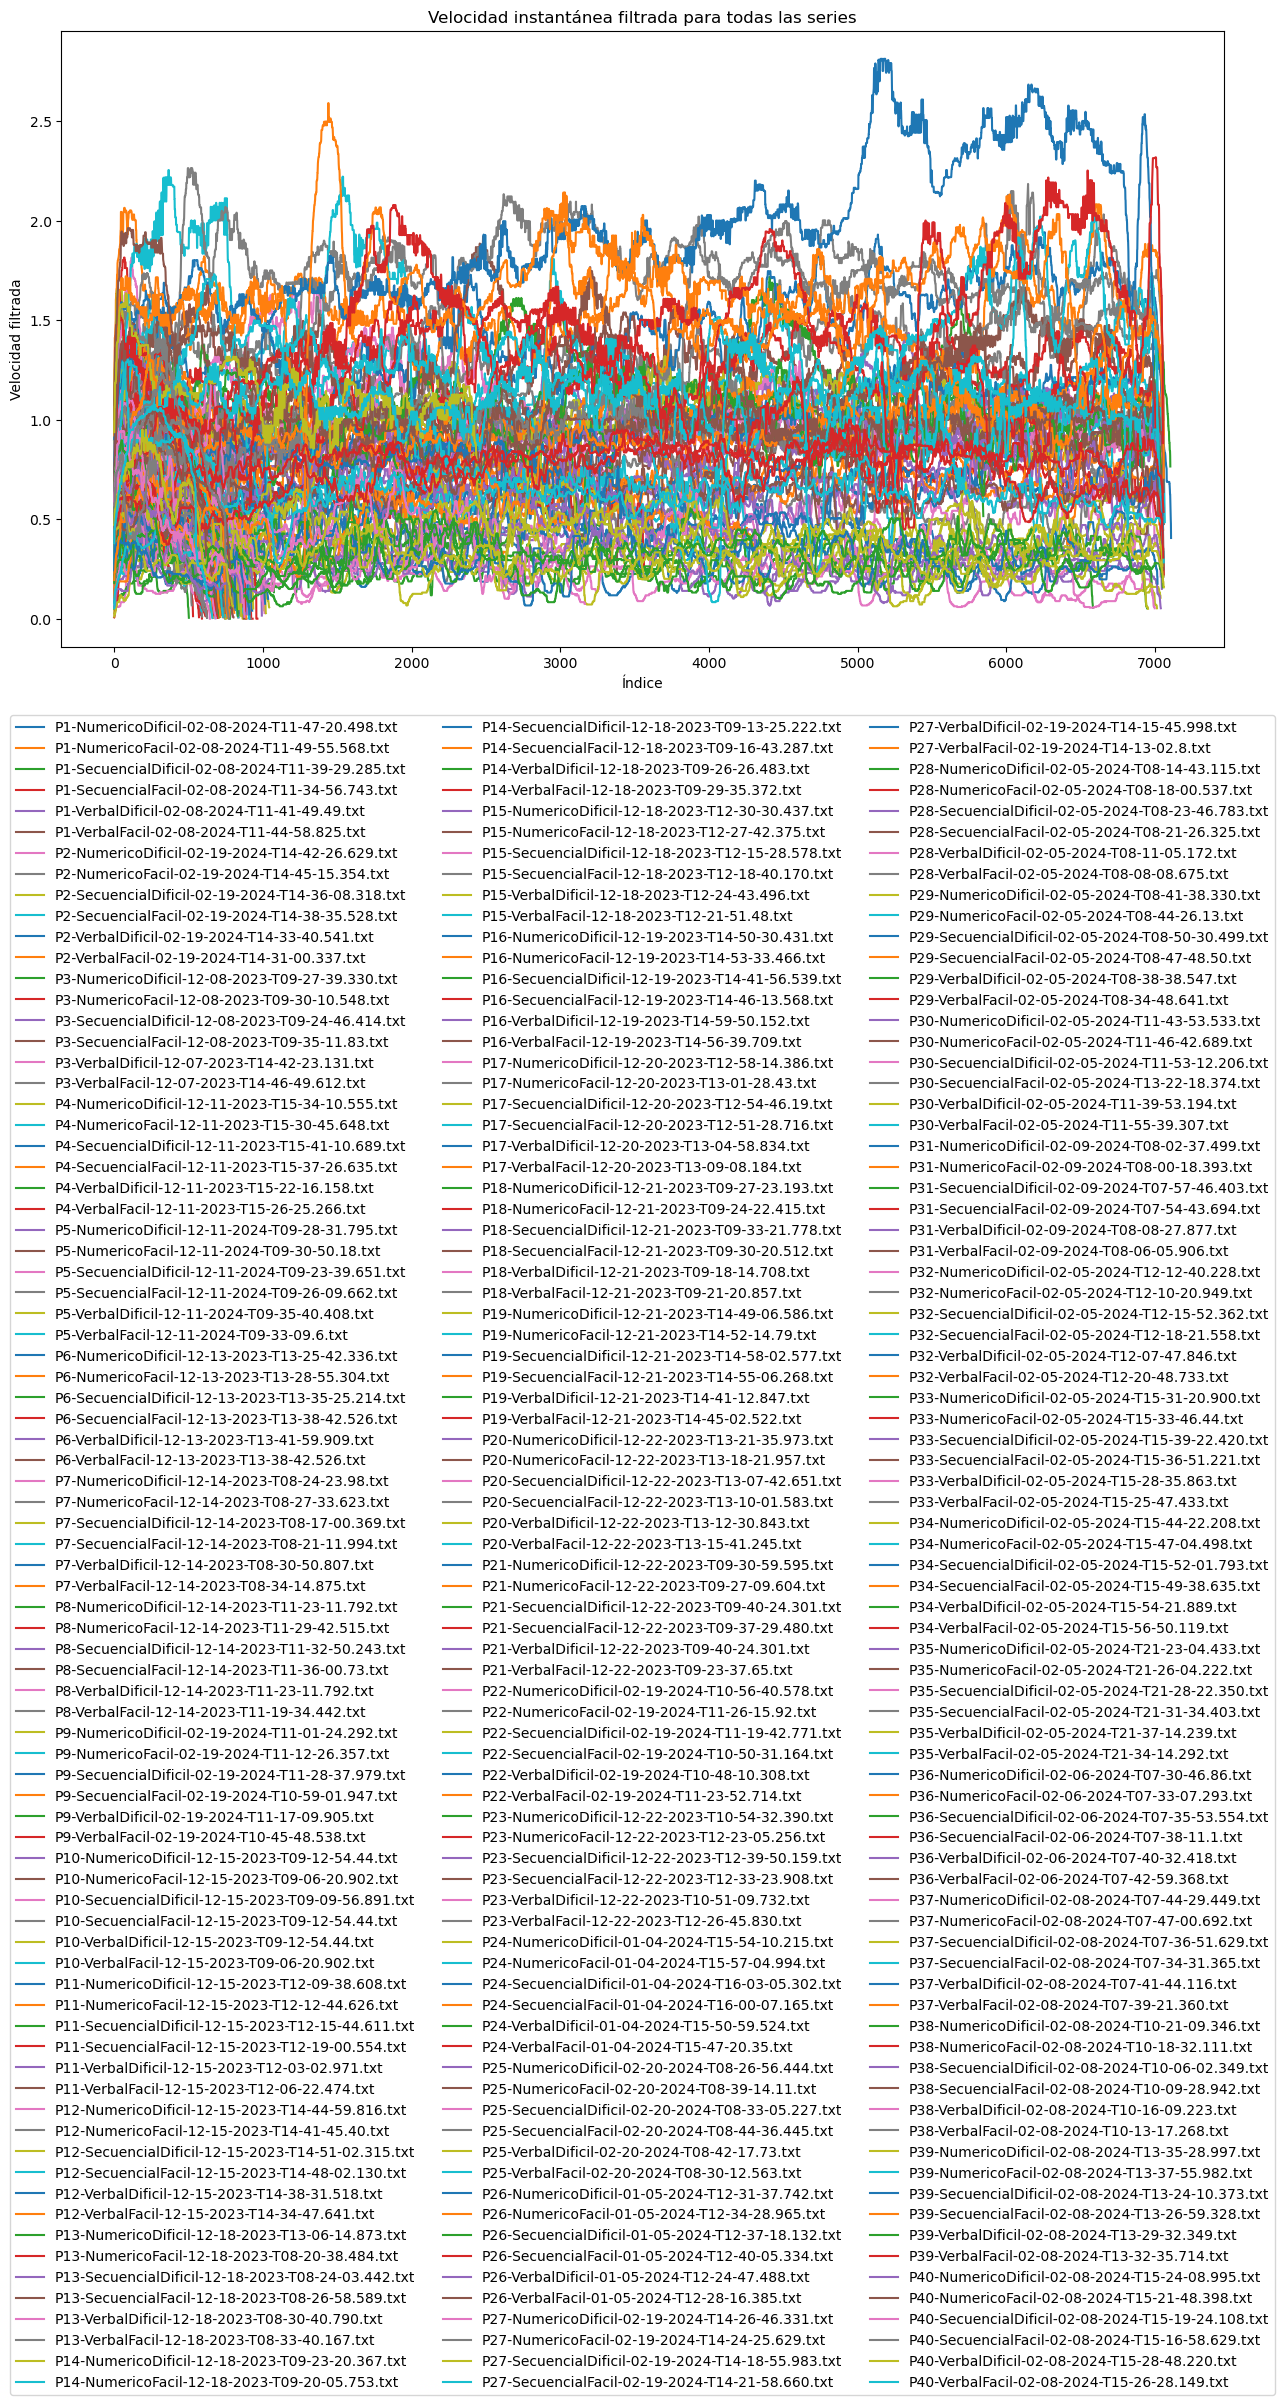

In [15]:
from scipy.signal import medfilt
# Función para aplicar el filtro mediano y guardar las series procesadas
def aplicar_filtro_y_graficar(velocidades_por_archivo, tamaño_ventana, archivo_salida_filtradas):
    velocidades_filtradas = {}
    datos_para_csv_filtradas = []

    # Aplicar el filtro mediano a cada serie de velocidad procesada
    for archivo, velocidades in velocidades_por_archivo.items():
        velocidades_filtradas[archivo] = medfilt(velocidades, tamaño_ventana)/1000



    # Creación del DataFrame y exportación a CSV para las series filtradas
    df_velocidades_filtradas = pd.DataFrame(datos_para_csv_filtradas, columns=['Participante', 'Tarea', 'Dificultad', 'Velocidad'])
    # Graficar las series de velocidad filtradas
    plt.figure(figsize=(15, 8))
    for archivo, velocidad in velocidades_filtradas.items():
        plt.plot(velocidad, label=archivo)
    plt.xlabel('Índice')
    plt.ylabel('Velocidad filtrada')
    plt.title('Velocidad instantánea filtrada para todas las series')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), shadow=False, ncol=3)
    plt.show()

    return velocidades_filtradas

# Definimos el tamaño de la ventana para el filtro mediano
tamaño_ventana = 91  # Tamaño de la ventana del filtro mediano

# Ejemplo de uso

archivo_salida_filtradas = 'velocidades_filtradas.csv'

velocidades_filtradas = aplicar_filtro_y_graficar(velocidades_por_archivo, tamaño_ventana, archivo_salida_filtradas)

In [16]:
print(velocidades_filtradas)

{'P1-NumericoDificil-02-08-2024-T11-47-20.498.txt': array([0.5858287 , 0.5858287 , 0.6757304 , ..., 0.25      , 0.25      ,
       0.24253563]), 'P1-NumericoFacil-02-08-2024-T11-49-55.568.txt': array([0.3354102 , 0.36400549, 0.36400549, ..., 0.58843894, 0.58823529,
       0.55555556]), 'P1-SecuencialDificil-02-08-2024-T11-39-29.285.txt': array([0.71869947, 0.71869947, 0.76923077, 0.82034619, 0.84865871,
       0.86322208, 0.86780552, 0.88888889, 0.89473684, 0.9503232 ,
       0.9503232 , 0.9503232 , 0.9503232 , 0.9503232 , 0.9503232 ,
       0.9701425 , 0.9701425 , 0.97901865, 0.97901865, 1.        ,
       1.        , 1.        , 1.        , 1.01203827, 1.02730878,
       1.05431032, 1.05701653, 1.06045626, 1.06045626, 1.06045626,
       1.06114705, 1.06114705, 1.06114705, 1.06114705, 1.06114705,
       1.07347779, 1.07347779, 1.07347779, 1.07529066, 1.07529066,
       1.07529066, 1.09431753, 1.09431753, 1.10750282, 1.11026437,
       1.11026437, 1.11026437, 1.10750282, 1.10750282, 1.

In [17]:

longitudes_valores = {}
for clave, valor in velocidades_filtradas.items():
    # Verificamos si el valor es un tipo de dato con longitud
    if hasattr(valor, '__len__'):
        longitudes_valores[clave] = len(valor)
    else:
        print(f"El valor asociado a la clave '{clave}' no tiene longitud.")

# Imprimimos el diccionario de longitudes de los valores
#print(longitudes_valores)

In [75]:
import os
import re

folder_directory = 'C:\\Users\\Rodne\\Desktop\\drawingsFiltered8\\'

# Función para extraer la clave de ordenación basada en el nombre del archivo
def obtener_clave(archivo):
    # Extraer el número de participante y luego el resto de los componentes del nombre
    patron = r"P(\d+)-(\w+)-(\w+)-"
    coincidencia = re.match(patron, archivo)
    if coincidencia:
        numero_participante = int(coincidencia.group(1))
        tarea = coincidencia.group(2)
        dificultad = coincidencia.group(3)
        return (numero_participante, tarea, dificultad)
    return archivo

# Obtener la lista de archivos y ordenarlos según el patrón personalizado
archivos = sorted([f for f in os.listdir(folder_directory) if f.endswith('.txt')],
                  key=obtener_clave)



In [19]:
import os
import pandas as pd
import numpy as np
from scipy.signal import medfilt
import matplotlib.pyplot as plt

porcentaje_eliminar = 0.5  

velocidades_resampled = dict()

for archivo in archivos:
    if archivo.endswith('.txt'):
        ruta_completa = os.path.join(folder_directory, archivo)
        df_tmp = pd.read_csv(ruta_completa, header=None, names=['x', 'y', 'timestamp'])

        # Eliminar el porcentaje de datos del inicio y del final
        filas_a_eliminar = int(len(df_tmp) * porcentaje_eliminar / 100)
        df_tmp = df_tmp.iloc[filas_a_eliminar:-filas_a_eliminar] if filas_a_eliminar > 0 else df_tmp

        df_tmp["timestamp"] = pd.to_datetime(df_tmp["timestamp"], unit="ms")
        instante_inicial = df_tmp.iloc[0]["timestamp"]
        df_tmp["timestamp"] = df_tmp["timestamp"] - instante_inicial
        
        # Establecer timestamp como índice
        df_tmp.set_index('timestamp', inplace=True)
        
        # Realizar resampling
        df_resampled = df_tmp.resample(freq).mean().interpolate()

        # Volver a calcular las velocidades para las series resampleadas
        df_resampled.reset_index(inplace=True)
        df_resampled['timestamp'] = df_resampled['timestamp'].dt.total_seconds()
        distancias = np.sqrt(np.diff(df_resampled['x'])**2 + np.diff(df_resampled['y'])**2)
        tiempos = np.diff(df_resampled['timestamp'])
        velocidades_instantaneas = np.divide(distancias, tiempos, out=np.zeros_like(distancias), where=tiempos>0)      
        velocidades_resampled[archivo] = velocidades_instantaneas

# Ejemplo de cómo graficar la velocidad resampleada para una serie específica
archivo_ejemplo = 'Modified_P46-VerbalDificil.txt'
if archivo_ejemplo in velocidades_resampled:
    plt.figure(figsize=(10, 6))
    plt.plot(velocidades_resampled[archivo_ejemplo])
    plt.xlabel('Índice')
    plt.ylabel('Velocidad')
    plt.title(f'Velocidad instantánea resampleada para {archivo_ejemplo}')
    plt.show()


In [20]:
min_interpolacion = 0
max_interpolacion = 1

# Determinar la longitud máxima entre todas las series resampleadas
max_longitud = max([len(v) for v in velocidades_resampled.values()])

max_longitud=8020
# Diccionario para almacenar las velocidades estiradas
velocidades_estiradas = {}


for key, velocidad in velocidades_resampled.items():
    longitud_actual = len(velocidad)
    x_shorter = np.linspace(min_interpolacion, max_interpolacion, longitud_actual)
    x_longer = np.linspace(min_interpolacion, max_interpolacion, max_longitud)
    interpolator = interp1d(x_shorter, velocidad, kind='linear', fill_value="extrapolate")
    stretched_velocidad = interpolator(x_longer)
    velocidades_estiradas[key] = stretched_velocidad


import os
import re

folder_directory = 'C:\\Users\\Rodne\\Desktop\\drawingsFiltered8\\'

# Función para extraer la clave de ordenación basada en el nombre del archivo
def obtener_clave(archivo):
    # Extraer el número de participante y luego el resto de los componentes del nombre
    patron = r"P(\d+)-(\w+)-(\w+)-"
    coincidencia = re.match(patron, archivo)
    if coincidencia:
        numero_participante = int(coincidencia.group(1))
        tarea = coincidencia.group(2)
        dificultad = coincidencia.group(3)
        return (numero_participante, tarea, dificultad)
    return archivo

# Obtener la lista de archivos y ordenarlos según el patrón personalizado
archivos = sorted([f for f in os.listdir(folder_directory) if f.endswith('.txt')],
                  key=obtener_clave)

# Imprimir el orden de los archivos para verificar
print("Orden de procesamiento de archivos:")
for archivo in archivos:
    print(archivo)

In [79]:
series_estiradas_ordenadas = {archivo: series_estiradas[archivo] for archivo in archivos}

# Ahora realiza el etiquetado asegurando que sigue el orden correcto
datos_transformados = []
etiquetas = []

def obtener_etiqueta(nombre_archivo):
    if 'Facil' in nombre_archivo:
        return 'facil'
    elif 'Dificil' in nombre_archivo:
        return 'dificil'
    else:
        return 'desconocido'

# Determinar el número máximo de coordenadas en X y Y para nombrar las columnas
max_len_x = max([df.shape[0] for df in series_estiradas_ordenadas.values()])
nombres_columnas = ['X{}'.format(i+1) for i in range(max_len_x)] + ['Y{}'.format(i+1) for i in range(max_len_x)]

# Transformar cada serie y almacenar los datos transformados y las etiquetas
for archivo, df in series_estiradas_ordenadas.items():
    # Obtener la etiqueta de la serie
    etiqueta = obtener_etiqueta(archivo)
    
    # Aplanar las series X e Y en un solo arreglo o lista
    datos_serie = df['x'].tolist() + df['y'].tolist()
    
    # Asegurarse de que cada serie tenga la misma longitud
    datos_serie.extend([np.nan] * (2 * max_len_x - len(datos_serie)))
    
    # Agregar los datos transformados y la etiqueta a las listas
    datos_transformados.append(datos_serie)
    etiquetas.append(etiqueta)

# Crear el DataFrame final con nombres de columnas
df_final = pd.DataFrame(datos_transformados, columns=nombres_columnas)
df_final['etiqueta'] = etiquetas

# Mostrar el DataFrame final
num_columnas_mostrar = 1

# Obtener las primeras y últimas columnas a mostrar
columnas_iniciales = df_final.columns[:num_columnas_mostrar].tolist()
columnas_finales = df_final.columns[-num_columnas_mostrar-1:].tolist()  # -1 para incluir la columna de etiquetas

# Combinar las columnas seleccionadas
columnas_seleccionadas = columnas_iniciales + columnas_finales

# Mostrar las columnas seleccionadas del DataFrame
print(df_final[columnas_seleccionadas])

       X1  Y8021 etiqueta
0   635.0  421.0  dificil
1   492.0  131.0    facil
2   353.0  424.0  dificil
3   443.0  156.0    facil
4   384.0  184.0  dificil
5   562.5  261.0    facil
6   478.0  246.0  dificil
7   568.0  139.0    facil
8   477.0  354.0  dificil
9   605.0  256.0    facil
10  543.0  196.0  dificil
11  417.0  387.0    facil
12  332.0  204.0  dificil
13  421.0  244.0    facil
14  646.0  375.0  dificil
15  324.0  360.0    facil
16  340.0  438.0  dificil
17  604.0  329.0    facil
18  503.0  155.0  dificil
19  584.0  369.0    facil
20  605.0  225.0  dificil
21  590.0  445.0    facil
22  582.0  120.0  dificil
23  369.0  233.0    facil
24  636.0  232.0  dificil
25  479.0  250.0    facil
26  427.5  418.0  dificil
27  340.0  275.5    facil
28  606.0  225.0  dificil
29  439.0  323.0    facil
30  338.0  417.0  dificil
31  545.0  305.0    facil
32  571.0  400.0  dificil
33  481.0  358.0    facil
34  529.0  312.0  dificil
35  354.0  308.0    facil
36  426.0  199.0  dificil
37  568.0  3

In [21]:
# Ordenar las series recortadas en el mismo orden que los archivos
series_recortadas_ordenadas = {archivo: series_recortadas[archivo] for archivo in archivos}

# Ahora realiza el etiquetado asegurando que sigue el orden correcto
datos_transformados = []
etiquetas = []

def obtener_etiqueta(nombre_archivo):
    if 'Facil' in nombre_archivo:
        return 'facil'
    elif 'Dificil' in nombre_archivo:
        return 'dificil'
    else:
        return 'desconocido'

# 🔥 Determinar la cantidad mínima de puntos después del recorte
min_len_x = min([df.shape[0] for df in series_recortadas_ordenadas.values()])
print(f"La cantidad mínima de puntos en las series después del recorte es: {min_len_x}")

# Crear nombres de columnas
nombres_columnas = ['X{}'.format(i+1) for i in range(min_len_x)] + ['Y{}'.format(i+1) for i in range(min_len_x)]

# Transformar cada serie y almacenar los datos transformados y las etiquetas
for archivo, df in series_recortadas_ordenadas.items():
    # Obtener la etiqueta de la serie
    etiqueta = obtener_etiqueta(archivo)
    
    # 📌 Asegurar que todas las series tienen exactamente `min_len_x` filas
    if df.shape[0] > min_len_x:
        df = df.iloc[:min_len_x]  # Cortar el exceso de puntos
    elif df.shape[0] < min_len_x:
        df = df.reindex(range(min_len_x), method='nearest')  # Interpolar si es menor

    # Aplanar las series X e Y en un solo arreglo
    datos_serie = df['x'].tolist() + df['y'].tolist()

    # 🔥 Verificar que la cantidad de puntos sea correcta
    if len(datos_serie) != 2 * min_len_x:
        print(f"Error en {archivo}: longitud esperada {2 * min_len_x}, obtenida {len(datos_serie)}")

    # Agregar los datos transformados y la etiqueta a las listas
    datos_transformados.append(datos_serie)
    etiquetas.append(etiqueta)

# 🚀 Verificar la cantidad exacta de columnas antes de crear el DataFrame
print(f"Número esperado de columnas: {len(nombres_columnas)}")
print(f"Número real de elementos en una fila: {len(datos_transformados[0])}")

# Crear el DataFrame final
df_final = pd.DataFrame(datos_transformados, columns=nombres_columnas)
df_final['etiqueta'] = etiquetas

# Mostrar una parte del DataFrame para verificar
print(df_final.head())

La cantidad mínima de puntos en las series después del recorte es: 6673
Número esperado de columnas: 13346
Número real de elementos en una fila: 13346
           X1          X2          X3          X4          X5          X6  \
0  617.000000  613.000000  609.000000  605.000000  596.600000  588.200000   
1  521.000000  514.000000  508.000000  499.000000  490.000000  481.000000   
2  470.333333  462.000000  452.166667  442.333333  432.500000  422.666667   
3  389.333333  379.666667  370.000000  366.333333  362.666667  359.000000   
4  347.666667  348.333333  349.000000  349.666667  350.333333  351.000000   

           X7          X8     X9    X10  ...       Y6665       Y6666  \
0  579.800000  571.400000  563.0  554.0  ...  438.000000  440.000000   
1  470.000000  462.500000  455.0  447.0  ...  154.000000  154.000000   
2  412.833333  403.000000  395.8  388.6  ...  472.434783  473.217391   
3  355.333333  351.666667  348.0  356.5  ...  248.717391  245.565217   
4  354.800000  358.600000 

In [22]:
# Determinar el número mínimo de coordenadas en X e Y para garantizar longitud uniforme
min_len_x = min([df.shape[0] for df in series_recortadas_ordenadas.values()])
nombres_columnas = ['X{}'.format(i+1) for i in range(min_len_x)] + ['Y{}'.format(i+1) for i in range(min_len_x)]

# Determinar la cantidad mínima de puntos en velocidad para alinearlo
min_len_velocity = min([len(v) for v in velocidades_estiradas.values()])
print(f"Cantidad mínima de puntos en velocidad: {min_len_velocity}")

# Agregar columnas de velocidad al DataFrame
nombres_columnas += ['V{}'.format(i+1) for i in range(min_len_velocity)]

# Transformar cada serie y almacenar los datos transformados y las etiquetas
datos_transformados = []
etiquetas = []

for archivo, df in series_recortadas_ordenadas.items():
    etiqueta = obtener_etiqueta(archivo)

    # 📌 Asegurar que todas las series X e Y tengan exactamente `min_len_x` filas
    if df.shape[0] > min_len_x:
        df = df.iloc[:min_len_x]  # Cortar el exceso de puntos
    elif df.shape[0] < min_len_x:
        df = df.reindex(range(min_len_x), method='nearest')  # Interpolar si es menor

    # Aplanar las series X e Y en un solo arreglo
    datos_serie = df['x'].tolist() + df['y'].tolist()

    # 📌 Obtener la serie de velocidad alineada
    velocidad_serie = velocidades_estiradas[archivo]

    # Asegurar que la serie de velocidad tenga exactamente `min_len_velocity` filas
    if len(velocidad_serie) > min_len_velocity:
        velocidad_serie = velocidad_serie[:min_len_velocity]  # Cortar si es más larga
    elif len(velocidad_serie) < min_len_velocity:
        velocidad_serie = np.pad(velocidad_serie, (0, min_len_velocity - len(velocidad_serie)), mode='edge')

    # Aplanar la serie de velocidad
    datos_serie += velocidad_serie.tolist()

    # Agregar los datos transformados y la etiqueta a las listas
    datos_transformados.append(datos_serie)
    etiquetas.append(etiqueta)

# Crear el DataFrame final con coordenadas X, Y y velocidad
df_final = pd.DataFrame(datos_transformados, columns=nombres_columnas)
df_final['etiqueta'] = etiquetas

# Mostrar información sobre el DataFrame final
print(df_final.head())
print(f"Dimensiones del DataFrame final: {df_final.shape}")


Cantidad mínima de puntos en velocidad: 8020
           X1          X2          X3          X4          X5          X6  \
0  617.000000  613.000000  609.000000  605.000000  596.600000  588.200000   
1  521.000000  514.000000  508.000000  499.000000  490.000000  481.000000   
2  470.333333  462.000000  452.166667  442.333333  432.500000  422.666667   
3  389.333333  379.666667  370.000000  366.333333  362.666667  359.000000   
4  347.666667  348.333333  349.000000  349.666667  350.333333  351.000000   

           X7          X8     X9    X10  ...        V8012       V8013  \
0  579.800000  571.400000  563.0  554.0  ...   336.501911  405.517502   
1  470.000000  462.500000  455.0  447.0  ...  1024.550695  569.600250   
2  412.833333  403.000000  395.8  388.6  ...   131.649366  131.649366   
3  355.333333  351.666667  348.0  356.5  ...   145.568543  145.568543   
4  354.800000  358.600000  362.4  366.2  ...   518.822599  518.822599   

        V8014        V8015        V8016        V8017 

In [80]:
# Assuming max_len_velocity represents the maximum length of velocity data across all series
max_len_velocity = max([len(v) for v in velocidades_estiradas.values()])
nombres_columnas += ['V{}'.format(i+1) for i in range(max_len_velocity)]

datos_transformados = []
etiquetas = []

for archivo, df in series_estiradas_ordenadas.items():
    etiqueta = obtener_etiqueta(archivo)
    
    # Flatten X, Y, and velocity series into a single list
    datos_serie = df['x'].tolist() + df['y'].tolist()
    
    # Retrieve the corresponding velocity data and flatten
    velocidad_serie = velocidades_estiradas[archivo].tolist()
    
    # Ensure each series (X, Y, velocity) has the same length
    total_length = 2 * max_len_x + max_len_velocity
    datos_serie.extend(velocidad_serie + [np.nan] * (total_length - len(datos_serie) - len(velocidad_serie)))
    
    datos_transformados.append(datos_serie)
    etiquetas.append(etiqueta)

df_final = pd.DataFrame(datos_transformados, columns=nombres_columnas)
df_final['etiqueta'] = etiquetas

print(df_final)
print(max_len_velocity)

       X1          X2          X3          X4          X5          X6  \
0   635.0  635.000000  632.075561  625.264464  616.453367  606.629676   
1   492.0  479.256110  465.551621  450.886534  437.103242  422.477556   
2   353.0  368.573067  384.146135  399.719202  416.185536  430.998753   
3   443.0  451.828304  460.656608  469.484913  479.236908  489.046135   
4   384.0  372.209476  362.349127  354.418953  350.279302  348.174564   
5   562.5  562.990960  563.000000  561.581359  560.108479  555.451995   
6   478.0  491.806234  504.640150  517.460224  530.280299  542.169576   
7   568.0  561.197257  552.507232  542.845387  533.127182  522.549875   
8   477.0  489.816833  502.633666  515.450499  528.267332  542.013716   
9   605.0  583.375810  566.580798  549.871197  532.229925  515.451995   
10  543.0  536.107357  528.245387  522.276060  516.368080  503.996883   
11  417.0  426.900249  437.780549  447.700748  458.561097  468.501247   
12  332.0  350.763092  371.476309  393.177057  418.

<h1 style="font-size:18px;">Coordenada X y Y RandomForest y feature velocidad</h1>


<h1 style="font-size:18px;">Coordenada X y Y RandomForest y feature velocidad con MiniRocket</h1>


In [81]:
datos_transformados = []
etiquetas = []

for archivo, df in series_estiradas_ordenadas.items():
    etiqueta = obtener_etiqueta(archivo)
    
    # 8020 elementos después de eliminar el primero
    x_datos_ajustados = df['x'][1:].tolist()  # 8020 elementos
    y_datos_ajustados = df['y'][1:].tolist()  # 8020 elementos
    
    #velocidad también tiene 8020 elementos
    velocidad_serie = velocidades_estiradas[archivo].tolist()  
    
    datos_serie = x_datos_ajustados + y_datos_ajustados + velocidad_serie
    
    # Verificar que la longitud de la serie sea la esperada (24060 puntos)
    assert len(x_datos_ajustados) == 8020, f"Longitud incorrecta para X en {archivo}: {len(x_datos_ajustados)}"
    assert len(y_datos_ajustados) == 8020, f"Longitud incorrecta para Y en {archivo}: {len(y_datos_ajustados)}"
    assert len(velocidad_serie) == 8020, f"Longitud incorrecta para velocidad en {archivo}: {len(velocidad_serie)}"
    assert len(datos_serie) == 24060, f"La longitud de la serie no es la esperada: {len(datos_serie)} para el archivo {archivo}"

    datos_transformados.append(datos_serie)
    etiquetas.append(etiqueta)

# Definir los nombres de las columnas para el nuevo DataFrame
nombres_columnas = ['X{}'.format(i+1) for i in range(8020)] + ['Y{}'.format(i+1) for i in range(8020)] + ['V{}'.format(i+1) for i in range(8020)]

# Crear el DataFrame final
df_finalVelocity = pd.DataFrame(datos_transformados, columns=nombres_columnas)
df_finalVelocity['etiqueta'] = etiquetas

In [82]:
print(len(velocidad_serie))

8020


In [83]:
from minirocket_multivariate import fit, transform
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Asume que df_finalVelocity ya está preparado con tus datos
X = df_finalVelocity.drop(columns=['etiqueta']).values  # Extrae las características
y = df_finalVelocity['etiqueta'].values  # Extrae las etiquetas

# Reforma X para que tenga la forma esperada por tu MiniRocket: (número de muestras, número de canales, longitud de la serie)
X_reshaped = X.reshape(-1, 3, 8020)  # -1 aquí infiere automáticamente el número de muestras, 3 para los canales (X, Y, velocidad)
X_reshaped = X_reshaped.astype(np.float32)  # Asegura que los datos sean float32

# Ajusta los parámetros de MiniRocket
params = fit(X_reshaped, num_features=100, max_dilations_per_kernel=84)

# Transforma los datos usando MiniRocket
X_transformed = transform(X_reshaped, params)

# Utiliza un clasificador RandomForest para evaluar el rendimiento
classifier = RandomForestClassifier(random_state=42)
scores = cross_val_score(classifier, X_transformed, y, cv=10)  

# Calcula y muestra la precisión promedio
accuracy_average = np.mean(scores)
print(f'Accuracy promedio con validación cruzada: {accuracy_average}')
print(scores)


Accuracy promedio con validación cruzada: 0.62
[0.6  0.6  0.4  0.6  0.8  1.   0.6  0.6  0.25 0.75]


In [84]:
print(df_finalVelocity)

            X1          X2          X3          X4          X5          X6  \
0   635.000000  632.075561  625.264464  616.453367  606.629676  593.982294   
1   479.256110  465.551621  450.886534  437.103242  422.477556  407.773067   
2   368.573067  384.146135  399.719202  416.185536  430.998753  447.278304   
3   451.828304  460.656608  469.484913  479.236908  489.046135  498.855362   
4   372.209476  362.349127  354.418953  350.279302  348.174564  348.000000   
5   562.990960  563.000000  561.581359  560.108479  555.451995  550.542394   
6   491.806234  504.640150  517.460224  530.280299  542.169576  554.920449   
7   561.197257  552.507232  542.845387  533.127182  522.549875  511.028928   
8   489.816833  502.633666  515.450499  528.267332  542.013716  555.816459   
9   583.375810  566.580798  549.871197  532.229925  515.451995  507.717456   
10  536.107357  528.245387  522.276060  516.368080  503.996883  494.828180   
11  426.900249  437.780549  447.700748  458.561097  468.501247  

<h1 style="font-size:20px;">Feature Radio-MiniRocket</h1>

In [85]:
datos_transformados = []
etiquetas = []


def obtener_etiqueta(nombre_archivo):
    if 'Facil' in nombre_archivo:
        return 'facil'
    elif 'Dificil' in nombre_archivo:
        return 'dificil'
    else:
        return 'desconocido'

# Determinar el número máximo de coordenadas en X y Y para nombrar las columnas
max_len_x = max([df.shape[0] for df in series_estiradas_ordenadas.values()])
nombres_columnas = ['X{}'.format(i+1) for i in range(max_len_x)] + ['Y{}'.format(i+1) for i in range(max_len_x)]

# Transformar cada serie y almacenar los datos transformados y las etiquetas
for archivo, df in series_estiradas_ordenadas.items():
    etiqueta = obtener_etiqueta(archivo)
    
    # Eliminar la primera columna (primer punto de datos) tanto para X como para Y
    df_ajustado = df.iloc[1:].reset_index(drop=True)
    
    # Aplanar las series X e Y ajustadas en un solo arreglo o lista
    datos_serie = df_ajustado['x'].tolist() + df_ajustado['y'].tolist()
    
    # Asegurarse de que cada serie tenga la misma longitud después del ajuste
    datos_serie.extend([np.nan] * (2 * (max_len_x - 1) - len(datos_serie)))
    
    # Agregar los datos transformados y la etiqueta a las listas
    datos_transformados.append(datos_serie)
    etiquetas.append(etiqueta)

# Crear el DataFrame final con nombres de columnas ajustados
nombres_columnas_ajustadas = ['X{}'.format(i+1) for i in range(max_len_x - 1)] + ['Y{}'.format(i+1) for i in range(max_len_x - 1)]
df_final = pd.DataFrame(datos_transformados, columns=nombres_columnas_ajustadas)
df_final['etiqueta'] = etiquetas

# Mostrar el DataFrame final
num_columnas_mostrar = 2

# Obtener las primeras y últimas columnas a mostrar
columnas_iniciales = df_final.columns[:num_columnas_mostrar].tolist()
columnas_finales = df_final.columns[-num_columnas_mostrar-1:].tolist()  # -1 para incluir la columna de etiquetas

# Combinar las columnas seleccionadas
columnas_seleccionadas = columnas_iniciales + columnas_finales

# Mostrar las columnas seleccionadas del DataFrame
print(df_final[columnas_seleccionadas])


datos_transformados = []
etiquetas = []

for archivo, df in series_estiradas.items():
    etiqueta = obtener_etiqueta(archivo)
    
    # 8020 elementos después de eliminar el primero
    x_datos_ajustados = df['x'][1:].tolist()  # 8020 elementos
    y_datos_ajustados = df['y'][1:].tolist()  # 8020 elementos
    
    #velocidad también tiene 8020 elementos
    velocidad_serie = velocidades_estiradas[archivo].tolist()  
    
    datos_serie = x_datos_ajustados + y_datos_ajustados + velocidad_serie
    
    # Verificar que la longitud de la serie sea la esperada (24060 puntos)
    assert len(x_datos_ajustados) == 8020, f"Longitud incorrecta para X en {archivo}: {len(x_datos_ajustados)}"
    assert len(y_datos_ajustados) == 8020, f"Longitud incorrecta para Y en {archivo}: {len(y_datos_ajustados)}"
    assert len(velocidad_serie) == 8020, f"Longitud incorrecta para velocidad en {archivo}: {len(velocidad_serie)}"
    assert len(datos_serie) == 24060, f"La longitud de la serie no es la esperada: {len(datos_serie)} para el archivo {archivo}"

    datos_transformados.append(datos_serie)
    etiquetas.append(etiqueta)

# Definir los nombres de las columnas para el nuevo DataFrame
nombres_columnas = ['X{}'.format(i+1) for i in range(8020)] + ['Y{}'.format(i+1) for i in range(8020)] + ['V{}'.format(i+1) for i in range(8020)]

# Crear el DataFrame final
df_finalVelocity = pd.DataFrame(datos_transformados, columns=nombres_columnas)
df_finalVelocity['etiqueta'] = etiquetas


            X1          X2       Y8019  Y8020 etiqueta
0   635.000000  632.075561  419.880939  421.0  dificil
1   479.256110  465.551621  136.881796  131.0    facil
2   368.573067  384.146135  423.026683  424.0  dificil
3   451.828304  460.656608  158.615794  156.0    facil
4   372.209476  362.349127  183.317215  184.0  dificil
5   562.990960  563.000000  259.859706  261.0    facil
6   491.806234  504.640150  243.684669  246.0  dificil
7   561.197257  552.507232  144.218253  139.0    facil
8   489.816833  502.633666  349.234767  354.0  dificil
9   583.375810  566.580798  253.350396  256.0    facil
10  536.107357  528.245387  197.025691  196.0  dificil
11  426.900249  437.780549  389.970075  387.0    facil
12  350.763092  371.476309  204.987531  204.0  dificil
13  425.939526  431.854863  245.481858  244.0    facil
14  644.024190  643.024190  372.530237  375.0  dificil
15  328.938279  332.901247  374.814838  360.0    facil
16  334.041895  331.041895  440.979052  438.0  dificil
17  593.13

In [86]:
datos_transformados = []
etiquetas = []

import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

series_originales = series_resampled
# Asumiendo que tienes un diccionario de DataFrames con tus series originales
# Paso 1: Calcular el promedio de X e Y para cada serie de tiempo
promedios = {key: (df['x'].mean(), df['y'].mean()) for key, df in series_originales.items()}

# Paso 2: Calcular la distancia euclidiana para cada punto en la serie respecto al promedio
distancias_euclidianas = {}
for key, df in series_originales.items():
    promedio_x, promedio_y = promedios[key]
    distancias = np.sqrt((df['x'] - promedio_x) ** 2 + (df['y'] - promedio_y) ** 2)
    distancias_euclidianas[key] = distancias

# Paso 3: Realizar el stretching de las distancias euclidianas
max_longitud = max(len(distancias) for distancias in distancias_euclidianas.values())
max_longitud=8021
distancias_estiradas = {}
for key, distancias in distancias_euclidianas.items():
    x_original = np.linspace(0, 1, len(distancias))
    x_stretch = np.linspace(0, 1, max_longitud)
    interpolator = interp1d(x_original, distancias, kind='linear', fill_value="extrapolate")
    distancias_estiradas[key] = interpolator(x_stretch)


for archivo, df in series_estiradas_ordenadas.items():
    etiqueta = obtener_etiqueta(archivo)
    
    # Datos de X, Y y velocidad ya ajustados a 8020 elementos
    x_datos_ajustados = df['x'][1:].tolist()
    y_datos_ajustados = df['y'][1:].tolist()
    velocidad_serie = velocidades_estiradas[archivo].tolist()
    
    # Ajustar la distancia euclidiana a 8020 elementos
    distancia_euclidiana_ajustada = distancias_estiradas[archivo][1:].tolist()

    # Concatenar X, Y, velocidad y distancia euclidiana
    datos_serie = x_datos_ajustados + y_datos_ajustados + velocidad_serie + distancia_euclidiana_ajustada
    
    assert len(datos_serie) == 8020 * 4, f"La longitud de la serie no es la esperada: {len(datos_serie)} para el archivo {archivo}"

    datos_transformados.append(datos_serie)
    etiquetas.append(etiqueta)

# Definir los nombres de las columnas para el nuevo DataFrame
nombres_columnas = ['X{}'.format(i+1) for i in range(8020)] + ['Y{}'.format(i+1) for i in range(8020)] + ['V{}'.format(i+1) for i in range(8020)] + ['D{}'.format(i+1) for i in range(8020)]

# Crear el DataFrame final
df_final_extended = pd.DataFrame(datos_transformados, columns=nombres_columnas)
df_final_extended['etiqueta'] = etiquetas



In [87]:
from minirocket_multivariate import fit, transform
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

# Asume que df_finalVelocity ya está preparado con tus datos
X = df_final_extended.drop(columns=['etiqueta']).values  # Extrae las características
y = df_final_extended['etiqueta'].values  # Extrae las etiquetas

# Reforma X para que tenga la forma esperada por tu MiniRocket: (número de muestras, número de canales, longitud de la serie)
X_reshaped = X.reshape(-1, 4, 8020)  # -1 aquí infiere automáticamente el número de muestras, 3 para los canales (X, Y, velocidad)
X_reshaped = X_reshaped.astype(np.float32)  # Asegura que los datos sean float32

# Ajusta los parámetros de MiniRocket
params = fit(X_reshaped, num_features=100, max_dilations_per_kernel=84)

# Transforma los datos usando MiniRocket
X_transformed = transform(X_reshaped, params)

# Utiliza un clasificador RandomForest para evaluar el rendimiento
classifier = RandomForestClassifier()
scores = cross_val_score(classifier, X_transformed, y, cv=10)  
# Calcula y muestra la precisión promedio
accuracy_average = np.mean(scores)
print(f'Accuracy promedio con validación cruzada: {accuracy_average}')
print(scores)

y_pred = cross_val_predict(classifier, X_transformed, y, cv=10)

# Calcula la matriz de confusión, especificando el orden de las etiquetas
conf_matrix = confusion_matrix(y, y_pred, labels=["facil", "dificil"])

# Imprime la matriz de confusión
print("Matriz de confusión:")
print(conf_matrix)

Accuracy promedio con validación cruzada: 0.6900000000000001
[0.8 0.6 0.2 0.6 0.8 0.8 1.  0.6 1.  0.5]
Matriz de confusión:
[[15  9]
 [11 13]]


<h1 style="font-size:16px;">"ANALISIS NUEVO FEATURE ACELERACION"</h1>

In [88]:
# Diccionario para almacenar las aceleraciones calculadas de cada archivo
aceleraciones_por_archivo = {}

for key, velocidades in velocidades_resampled.items():
    aceleraciones = [0]  # Inicializar el primer valor de aceleración como 0
    for i in range(1, len(velocidades)):
        # Calcular aceleración como cambio de velocidad dividido por cambio de tiempo
        # Asumiendo que el cambio de tiempo (delta_t) es constante y se deriva de la frecuencia de resampling
        delta_v = velocidades[i] - velocidades[i - 1]
        delta_t = 0.015  # Cambiar según tu frecuencia de resampling real
        aceleracion = delta_v / delta_t
        aceleraciones.append(aceleracion)
    
    aceleraciones_por_archivo[key] = aceleraciones

# Estirar las aceleraciones para que todas tengan la misma longitud
max_len_aceleraciones = max([len(a) for a in aceleraciones_por_archivo.values()])
print(max_len_aceleraciones)
max_len_aceleraciones=8020
aceleraciones_estiradas = {}

for key, aceleracion in aceleraciones_por_archivo.items():
    longitud_actual = len(aceleracion)
    x_shorter = np.linspace(0, 1, longitud_actual)
    x_longer = np.linspace(0, 1, max_len_aceleraciones)
    interpolator = interp1d(x_shorter, aceleracion, kind='linear', fill_value="extrapolate")
    stretched_aceleracion = interpolator(x_longer)
    aceleraciones_estiradas[key] = stretched_aceleracion

# Crear un DataFrame para las aceleraciones
aceleraciones_df = pd.DataFrame({f'A{j}': np.nan for j in range(1, max_len_aceleraciones + 1)}, index=df_final.index)
for i, aceleracion in enumerate(aceleraciones_estiradas.values()):
    aceleraciones_df.iloc[i, :len(aceleracion)] = aceleracion

# Añadir las aceleraciones al DataFrame final antes de la columna 'etiqueta'
columnas_antes_etiqueta = df_final.columns.tolist()[:-1]  # Todas las columnas excepto 'etiqueta'
df_final_con_aceleraciones = pd.concat([df_final[columnas_antes_etiqueta], aceleraciones_df, df_final[['etiqueta']]], axis=1)

8028


In [89]:
print(df_final_con_aceleraciones)

            X1          X2          X3          X4          X5          X6  \
0   635.000000  632.075561  625.264464  616.453367  606.629676  593.982294   
1   479.256110  465.551621  450.886534  437.103242  422.477556  407.773067   
2   368.573067  384.146135  399.719202  416.185536  430.998753  447.278304   
3   451.828304  460.656608  469.484913  479.236908  489.046135  498.855362   
4   372.209476  362.349127  354.418953  350.279302  348.174564  348.000000   
5   562.990960  563.000000  561.581359  560.108479  555.451995  550.542394   
6   491.806234  504.640150  517.460224  530.280299  542.169576  554.920449   
7   561.197257  552.507232  542.845387  533.127182  522.549875  511.028928   
8   489.816833  502.633666  515.450499  528.267332  542.013716  555.816459   
9   583.375810  566.580798  549.871197  532.229925  515.451995  507.717456   
10  536.107357  528.245387  522.276060  516.368080  503.996883  494.828180   
11  426.900249  437.780549  447.700748  458.561097  468.501247  

In [90]:
datos_transformados = []
etiquetas = []

for archivo, df in series_estiradas_ordenadas.items():
    etiqueta = obtener_etiqueta(archivo)
    
    # Datos de X, Y y velocidad ya ajustados a 8020 elementos
    x_datos_ajustados = df['x'][1:].tolist()
    y_datos_ajustados = df['y'][1:].tolist()
    velocidad_serie = velocidades_estiradas[archivo].tolist()
    
    # Ajustar la distancia euclidiana y la aceleración a 8020 elementos
    distancia_euclidiana_ajustada = distancias_estiradas[archivo][1:].tolist()
    aceleracion_ajustada = aceleraciones_estiradas[archivo].tolist()

    # Concatenar X, Y, velocidad, distancia euclidiana y aceleración
    datos_serie = x_datos_ajustados + y_datos_ajustados + velocidad_serie + distancia_euclidiana_ajustada + aceleracion_ajustada
    
    assert len(datos_serie) == 8020 * 5, f"La longitud de la serie no es la esperada: {len(datos_serie)} para el archivo {archivo}"

    datos_transformados.append(datos_serie)
    etiquetas.append(etiqueta)

# Definir los nombres de las columnas para el nuevo DataFrame
nombres_columnas = ['X{}'.format(i+1) for i in range(8020)] + ['Y{}'.format(i+1) for i in range(8020)] + ['V{}'.format(i+1) for i in range(8020)] + ['D{}'.format(i+1) for i in range(8020)] + ['A{}'.format(i+1) for i in range(8020)]

# Crear el DataFrame final
df_final_extendedAceleration = pd.DataFrame(datos_transformados, columns=nombres_columnas)
df_final_extendedAceleration['etiqueta'] = etiquetas


<h1 style="font-size:16px;">"ANALISIS VELOCIDAD ANGULAR"</h1>

In [91]:
import os
import re

folder_directory = 'C:\\Users\\Rodne\\Desktop\\drawingsFiltered8\\'

# Función para extraer la clave de ordenación basada en el nombre del archivo
def obtener_clave(archivo):
    # Extraer el número de participante y luego el resto de los componentes del nombre
    patron = r"P(\d+)-(\w+)-(\w+)-"
    coincidencia = re.match(patron, archivo)
    if coincidencia:
        numero_participante = int(coincidencia.group(1))
        tarea = coincidencia.group(2)
        dificultad = coincidencia.group(3)
        return (numero_participante, tarea, dificultad)
    return archivo

# Obtener la lista de archivos y ordenarlos según el patrón personalizado
archivos = sorted([f for f in os.listdir(folder_directory) if f.endswith('.txt')],
                  key=obtener_clave)

# Imprimir el orden de los archivos para verificar
print("Orden de procesamiento de archivos:")
for archivo in archivos:
    print(archivo)

Orden de procesamiento de archivos:
Modified_P41-NumericoDificil.txt
Modified_P41-NumericoFacil.txt
Modified_P41-SecuencialDificil.txt
Modified_P41-SecuencialFacil.txt
Modified_P41-VerbalDificil.txt
Modified_P41-VerbalFacil.txt
Modified_P42-NumericoDificil.txt
Modified_P42-NumericoFacil.txt
Modified_P42-SecuencialDificil.txt
Modified_P42-SecuencialFacil.txt
Modified_P42-VerbalDificil.txt
Modified_P42-VerbalFacil.txt
Modified_P43-NumericoDificil.txt
Modified_P43-NumericoFacil.txt
Modified_P43-SecuencialDificil.txt
Modified_P43-SecuencialFacil.txt
Modified_P43-VerbalDificil.txt
Modified_P43-VerbalFacil.txt
Modified_P44-NumericoDificil.txt
Modified_P44-NumericoFacil.txt
Modified_P44-SecuencialDificil.txt
Modified_P44-SecuencialFacil.txt
Modified_P44-VerbalDificil.txt
Modified_P44-VerbalFacil.txt
Modified_P45-NumericoDificil.txt
Modified_P45-NumericoFacil.txt
Modified_P45-SecuencialDificil.txt
Modified_P45-SecuencialFacil.txt
Modified_P45-VerbalDificil.txt
Modified_P45-VerbalFacil.txt
Modi

In [92]:
import os
import pandas as pd
import numpy as np

porcentaje_eliminar = 0.5  # Porcentaje de eliminación al inicio y al final

# Función para calcular la velocidad angular respecto al centro
def calcular_velocidad_angular(df, centro):
    velocidades_angulares = []
    for i in range(1, len(df)):
        x1, y1, t1 = df.iloc[i - 1][['x', 'y', 'timestamp']]
        x2, y2, t2 = df.iloc[i][['x', 'y', 'timestamp']]
        
        # Calcular el ángulo en cada punto respecto al centro
        angulo1 = np.arctan2(y1 - centro[1], x1 - centro[0])
        angulo2 = np.arctan2(y2 - centro[1], x2 - centro[0])
        
        # Calcular el cambio en el ángulo y el tiempo
        delta_angulo = angulo2 - angulo1
        delta_tiempo = (t2 - t1) / 1000.0  # Convertir tiempo a segundos
        
        # Ajustar el cambio de ángulo para estar entre -pi y pi
        delta_angulo = (delta_angulo + np.pi) % (2 * np.pi) - np.pi
        
        if delta_tiempo > 0:
            velocidad_angular = delta_angulo / delta_tiempo
            velocidades_angulares.append(velocidad_angular)
        else:
            velocidades_angulares.append(0)
    
    return velocidades_angulares

# Diccionario para almacenar las velocidades angulares
velocidades_angulares_por_archivo = {}

for archivo in archivos:
    if archivo.endswith('.txt'):
        ruta_completa = os.path.join(folder_directory, archivo)
        df = pd.read_csv(ruta_completa, header=None, names=['x', 'y', 'timestamp'])
        
        # Eliminar filas al inicio y al final
        filas_a_eliminar = int(len(df) * porcentaje_eliminar / 100)
        df_reducido = df.iloc[filas_a_eliminar:-filas_a_eliminar] if filas_a_eliminar > 0 else df
        
        # Calcular el centro usando la mediana de las coordenadas X e Y
        centro = (df_reducido['x'].median(), df_reducido['y'].median())

        velocidades_angulares = calcular_velocidad_angular(df_reducido, centro)
        velocidades_angulares_por_archivo[archivo] = velocidades_angulares


In [93]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

# Supongamos que `velocidades_angulares_por_archivo` es tu diccionario con las velocidades angulares
# y cada archivo tiene su correspondiente dataframe con columnas 'timestamp', 'x', 'y'

freq = '0.0008954S'  # Definir la frecuencia de resampling

# Resampling y estiramiento
velocidades_angulares_resampled = {}


for key, velocidades in velocidades_angulares_por_archivo.items():
    # Crear un DataFrame para la serie temporal
    df = pd.DataFrame(velocidades, columns=['velocidad_angular'])
    df['timestamp'] = pd.to_datetime(df.index, unit='ms')  # Asumiendo que el índice es el timestamp en ms
    df.set_index('timestamp', inplace=True)
    
    # Resampling
    df_resampled = df.resample(freq).mean().interpolate()
    
    # Guardar la longitud máxima para el estiramiento posterior
    max_longitud = max(max_longitud, len(df_resampled))

    
    velocidades_angulares_resampled[key] = df_resampled['velocidad_angular'].tolist()

    
max_longitud = max([len(v) for v in velocidades_angulares_resampled.values()])    

velocidades_angulares_estiradas = {}
for key, velocidad_angular in velocidades_angulares_resampled.items():
    x_original = np.linspace(0, 1, len(velocidad_angular))
    max_longitud=8020
    x_stretch = np.linspace(0, 1, max_longitud)
    interpolator = interp1d(x_original, velocidad_angular, kind='linear', fill_value="extrapolate")
    stretched_velocidad_angular = interpolator(x_stretch)
    velocidades_angulares_estiradas[key] = stretched_velocidad_angular




In [100]:
datos_transformados = []
etiquetas = []

for archivo, df in series_estiradas_ordenadas.items():
    etiqueta = obtener_etiqueta(archivo)
    
    # Datos de X, Y y velocidad ya ajustados a 8020 elementos
    x_datos_ajustados = df['x'][1:].tolist()
    y_datos_ajustados = df['y'][1:].tolist()
    velocidad_serie = velocidades_estiradas[archivo].tolist()
    
    # Ajustar la distancia euclidiana y la aceleración a 8020 elementos
    distancia_euclidiana_ajustada = distancias_estiradas[archivo][1:].tolist()
    aceleracion_ajustada = aceleraciones_estiradas[archivo].tolist()
    velocidad_angular_ajustada = velocidades_angulares_estiradas[archivo].tolist()

    # Concatenar X, Y, velocidad, distancia euclidiana y aceleración
    datos_serie = x_datos_ajustados + y_datos_ajustados + velocidad_serie + distancia_euclidiana_ajustada + aceleracion_ajustada + velocidad_angular_ajustada
    
    assert len(datos_serie) == 8020 * 6, f"La longitud de la serie no es la esperada: {len(datos_serie)} para el archivo {archivo}"

    datos_transformados.append(datos_serie)
    etiquetas.append(etiqueta)

# Definir los nombres de las columnas para el nuevo DataFrame
nombres_columnas = ['X{}'.format(i+1) for i in range(8020)] + ['Y{}'.format(i+1) for i in range(8020)] + ['V{}'.format(i+1) for i in range(8020)] + ['D{}'.format(i+1) for i in range(8020)] + ['A{}'.format(i+1) for i in range(8020)] + ['VA{}'.format(i+1) for i in range(8020)]

# Crear el DataFrame final
df_final_extendedVelocidadAnglar = pd.DataFrame(datos_transformados, columns=nombres_columnas)
df_final_extendedVelocidadAnglar['etiqueta'] = etiquetas



In [101]:
print(len(velocidad_angular_ajustada))

8020


In [102]:
from minirocket_multivariate import fit, transform
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold


X = df_final_extendedVelocidadAnglar.drop(columns=['etiqueta']).values 
y = df_final_extendedVelocidadAnglar['etiqueta'].values 

# Reforma X para que tenga la forma esperada por tu MiniRocket: (número de muestras, número de canales, longitud de la serie)
X_reshaped = X.reshape(-1, 6, 8020)  # -1 aquí infiere automáticamente el número de muestras, 3 para los canales (X, Y, velocidad)
X_reshaped = X_reshaped.astype(np.float32)  #  los datos float32

# Ajusta los parámetros de MiniRocket
params = fit(X_reshaped, num_features=100, max_dilations_per_kernel=200)

# Transforma los datos usando MiniRocket
X_transformed = transform(X_reshaped, params)

# Clasificador RandomForest para evaluar el rendimiento
classifier = RandomForestClassifier()
scores = cross_val_score(classifier, X_transformed, y, cv=10)  
# Calcula y muestra la precisión promedio
accuracy_average = np.mean(scores)
print(f'Accuracy promedio con validación cruzada: {accuracy_average}')
print(scores)

y_pred = cross_val_predict(classifier, X_transformed, y, cv=10)

# Calcula la matriz de confusión, especificando el orden de las etiquetas
conf_matrix = confusion_matrix(y, y_pred, labels=["facil", "dificil"])
 
# Imprime la matriz de confusión
print("Matriz de confusión:")
print(conf_matrix)

Accuracy promedio con validación cruzada: 0.6100000000000001
[0.6  0.4  0.2  0.6  0.8  0.8  0.8  0.4  0.75 0.75]
Matriz de confusión:
[[16  8]
 [12 12]]


<h1 style="font-size:16px;">"DERIVADA DEL RADIO"</h1>

In [103]:
import os
import re

folder_directory = 'C:\\Users\\Rodne\\Desktop\\drawingsFiltered8\\'

# Función para extraer la clave de ordenación basada en el nombre del archivo
def obtener_clave(archivo):
    # Extraer el número de participante y luego el resto de los componentes del nombre
    patron = r"P(\d+)-(\w+)-(\w+)-"
    coincidencia = re.match(patron, archivo)
    if coincidencia:
        numero_participante = int(coincidencia.group(1))
        tarea = coincidencia.group(2)
        dificultad = coincidencia.group(3)
        return (numero_participante, tarea, dificultad)
    return archivo

# Obtener la lista de archivos y ordenarlos según el patrón personalizado
archivos = sorted([f for f in os.listdir(folder_directory) if f.endswith('.txt')],
                  key=obtener_clave)



In [104]:
import os
import pandas as pd
import numpy as np


porcentaje_eliminar = 0.5 


derivada_radio_por_archivo = {}

for archivo in archivos:
    if archivo.endswith('.txt'):
        ruta_completa = os.path.join(folder_directory, archivo)
        df = pd.read_csv(ruta_completa, names=['x', 'y', 'timestamp'], header=None)

        num_rows = len(df)
        to_remove = int(num_rows * porcentaje_eliminar / 100)
        df = df.iloc[to_remove:-to_remove]
        centro_x = df['x'].median()
        centro_y = df['y'].median()
        df['radio'] = np.sqrt((df['x'] - centro_x)**2 + (df['y'] - centro_y)**2)
        df['tiempo'] = pd.to_datetime(df['timestamp'], unit='ms')
        df['tiempo'] = (df['tiempo'] - df['tiempo'].iloc[0]).dt.total_seconds()
        
        df = df.drop_duplicates(subset='tiempo')
        df['derivada_radio'] = np.gradient(df['radio'], df['tiempo'])
        derivada_radio_por_archivo[archivo] = df['derivada_radio'].tolist()



In [105]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d


freq = '0.0008956S'  

# Resampling y estiramiento
velocidades_angulares_resampled = {}


for key, velocidades in derivada_radio_por_archivo.items():
    # Crear un DataFrame para la serie temporal
    df = pd.DataFrame(velocidades, columns=['velocidad_angular'])
    df['timestamp'] = pd.to_datetime(df.index, unit='ms')  # Asumiendo que el índice es el timestamp en ms
    df.set_index('timestamp', inplace=True)
    
    # Resampling
    df_resampled = df.resample(freq).mean().interpolate()
    
    # Guardar la longitud máxima para el estiramiento posterior
    max_longitud = max(max_longitud, len(df_resampled))
    
    velocidades_angulares_resampled[key] = df_resampled['velocidad_angular'].tolist()

    
max_longitud = max([len(v) for v in velocidades_angulares_resampled.values()])    

velocidades_angulares_estiradas_radio = {}
for key, velocidad_angular in velocidades_angulares_resampled.items():
    x_original = np.linspace(0, 1, len(velocidad_angular))
    max_longitud=8020
    x_stretch = np.linspace(0, 1, max_longitud)
    interpolator = interp1d(x_original, velocidad_angular, kind='linear', fill_value="extrapolate")
    stretched_velocidad_angular = interpolator(x_stretch)
    velocidades_angulares_estiradas_radio[key] = stretched_velocidad_angular


In [106]:
datos_transformados = []
etiquetas = []

for archivo, df in series_estiradas_ordenadas.items():
    etiqueta = obtener_etiqueta(archivo)
    
   
    x_datos_ajustados = df['x'][1:].tolist()
    y_datos_ajustados = df['y'][1:].tolist()
    velocidad_serie = velocidades_estiradas[archivo].tolist()
    distancia_euclidiana_ajustada = distancias_estiradas[archivo][1:].tolist()
    aceleracion_ajustada = aceleraciones_estiradas[archivo].tolist()
    velocidad_angular_ajustada = velocidades_angulares_estiradas[archivo].tolist()
    derivada_radio_ajustada = velocidades_angulares_estiradas_radio[archivo].tolist()
    datos_serie = x_datos_ajustados + y_datos_ajustados + velocidad_serie + distancia_euclidiana_ajustada + aceleracion_ajustada + velocidad_angular_ajustada + derivada_radio_ajustada 
    
    assert len(datos_serie) == 8020 * 7, f"La longitud de la serie no es la esperada: {len(datos_serie)} para el archivo {archivo}"

    datos_transformados.append(datos_serie)
    etiquetas.append(etiqueta)

nombres_columnas = ['X{}'.format(i+1) for i in range(8020)] + ['Y{}'.format(i+1) for i in range(8020)] + ['V{}'.format(i+1) for i in range(8020)] + ['D{}'.format(i+1) for i in range(8020)] + ['A{}'.format(i+1) for i in range(8020)] + ['VA{}'.format(i+1) for i in range(8020)] + ['DR{}'.format(i+1) for i in range(8020)]

df_final_extendedVelocidadAnglarDerivadaRadio8Participants = pd.DataFrame(datos_transformados, columns=nombres_columnas)
df_final_extendedVelocidadAnglarDerivadaRadio8Participants['etiqueta'] = etiquetas




In [107]:
df_final_8participants=df_final_extendedVelocidadAnglarDerivadaRadio8Participants

In [55]:
print(df_final_40participants)

             X1          X2          X3          X4          X5          X6  \
0    378.950623  390.868329  404.769576  422.604988  443.423940  467.209975   
1    454.875312  465.725686  476.588529  488.401496  500.251870  511.177057   
2    462.274314  442.548628  423.781796  405.987531  390.097257  376.152120   
3    621.979426  622.958853  623.000000  620.246883  613.720075  605.987531   
4    612.955611  613.000000  613.000000  610.266334  605.554863  599.799002   
..          ...         ...         ...         ...         ...         ...   
235  558.197257  549.507232  539.845387  530.127182  519.549875  508.028928   
236  474.816833  487.633666  500.450499  513.267332  527.013716  540.816459   
237  582.375810  565.580798  548.871197  531.229925  514.451995  506.717456   
238  427.900249  438.780549  448.700748  459.561097  469.501247  479.401496   
239  532.107357  524.245387  518.276060  512.368080  499.996883  490.828180   

             X7          X8          X9         X10